In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


# Загрузка данных


Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых 
центров

Price - цена квартиры

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
#Проверим действительно ли количество столбцов в тесте на 1 меньше, чем в трейне
train_df.shape[1] - 1 == test_df.shape[1]


True

## Приведение типов данных

In [11]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

Переведем Id  и DistrictId в строковый тип

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# EDA
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
# - Идей для генерации новых фич

###Целевая переменная



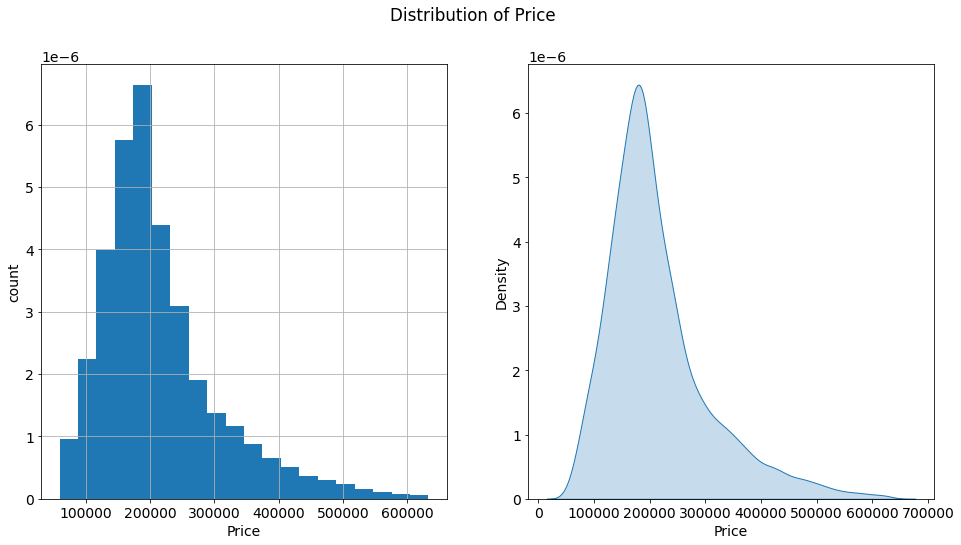

In [13]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=True, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

Вывод: наблюдаем мало дешевых объектов, много объектов со средней ценой и мало дорогих объектов.

### Количественные переменные



In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


1. Пропуски наблюдаются в двух признаках: *LifeSquare* и *Healthcare_1*
2. По различию между Средним и Медианой можно сделать выводы о наличии выбросов (среднее реагирует на выбросы больше, чем медиана): 
  - Rooms: 1.89 / 2.00 - отличие небольшое
  - Square: 56.31 / 65.90 - скорей всего справа можно наблюдать большие значения
  - LifeSquare 37.19 / 32.78 - предполагаем малые значения слева
  - KitchenSquare 6.27 / 6.00 - отличие небольшое
  - Floor и HouseFloor - отличие небольшое
  - HouseYear 3.99 / 1.97 - очень большое среднее, значит есть оч большое число справа
  - Остальные значения, кроме Healthcare_1  в норме
3. Min / Max значения:
  -   Rooms: 0 / 19 - неадекватные значения количества комнат
  - Square и LifeSquare : также неадекватные значения минимума и максимума
  - Floor: 0 / 117 - требует исправления
  

In [15]:
train_df['Rooms'].value_counts()


2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

***Rooms***:
- Всего 9 уникальных значений
- Больше всего 2х комнатных, затем 1-комнатных, а еще меньше 3х комнатных квартир
- количество комнат 10 и 19 возможно, если это большой дом или этаж, отданных под гостиницу (гостиница занимает один этаж дома и является по сути большой квартирой)
- количество комнат 0 невозможно (скорей всего ошибка при заполнении информации) и  таких объектов 8 шт

In [16]:
train_df['Square'].value_counts()


37.498161    2
65.285133    2
81.867165    2
80.794792    2
44.482914    2
            ..
35.660820    1
51.660706    1
71.321365    1
81.321167    1
44.000046    1
Name: Square, Length: 9995, dtype: int64

In [17]:
#train_df.sort_values(by="LifeSquare", inplace=True)
#test_df.head()

In [18]:
train_df['Square'].unique() 

array([115.02731 ,  39.832523,  78.34222 , ...,  29.648056,  32.33029 ,
        35.815475], dtype=float32)

In [19]:
train_df[(train_df['LifeSquare'] > train_df['Square'])]



,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314972,74.131264,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.375000
64,3992,1,3.0,87.200623,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.375000
77,11771,45,1.0,38.467278,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.531250
100,13343,74,2.0,79.937668,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.750000
111,13875,20,1.0,28.438793,32.514023,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.109375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056786,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.562500
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.382812
9979,2201,6,1.0,40.043236,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.078125
9987,11665,1,2.0,62.690056,64.602936,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.187500


In [20]:
train_df[(train_df['Square'] < 10)]



,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
328,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
1401,9487,5,1.0,5.129221,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.406250
4496,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250
4800,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.500000
5009,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
7033,1748,88,2.0,5.497061,67.628716,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
7470,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
8572,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
8805,10527,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750


***Square***:
- Все значения уникальны
- Есть 482 объекта, у которых Square > LifeSquare , чего не может быть
- Есть 12 наблюдений, у которых Square < 10, что очень сомнительно

In [21]:
train_df[train_df['LifeSquare'] < 6]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,8553,88,3.0,83.262527,4.769175,1.0,13,1.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,410883.906250
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174742.000000
161,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
212,1182,27,1.0,38.936985,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,93560.789062
227,3746,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,10079,59,1.0,48.232742,3.288779,1.0,15,17.0,2017,0.019509,B,B,37,7687,11,176.0,5,5,B,207086.640625
9869,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
9912,13523,23,1.0,52.787090,5.600609,1.0,7,1.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,104160.492188
9938,2913,34,4.0,94.888596,2.637095,1.0,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.500000


***LifeSquare***:
- Есть пропуски
- Все значения уникальны
- Есть 205 наблюдений, у которых Square < 6, что очень сомнительно

In [22]:
train_df['KitchenSquare'].value_counts()


1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

***KitchenSquare***:
- самое популярное значение -3 м2, затем 8 и 6 м2
- самые большие значения 2014 и 1970 явно перепутаны с годами



In [23]:
train_df['HouseFloor'].value_counts()


17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
48.0        2
39.0        2
44.0        1
36.0        1
26.0        1
45.0        1
29.0        1
38.0        1
47.0        1
117.0       1
31.0        1
Name: HouseFloor, dtype: int64

In [24]:
(train_df['Floor'] > train_df['HouseFloor']).sum()


1825

***HouseFloor***:
- в целом правдоподобные значения, за исключением самых больших - 117 этажей вряд ли бывает
- есть ряд наблюдений, где этаж больше чем этажность дома

###Номинативные переменные

In [25]:
df_obj_features = train_df.select_dtypes(include='object')
df_obj_features.head()

,Id,DistrictId
0,11809,27
1,3013,22
2,8215,1
3,2352,1
4,13866,94


**DistrictId**

In [26]:
train_df['DistrictId'].value_counts()


27     851
1      652
23     565
6      511
9      294
      ... 
205      1
199      1
196      1
207      1
174      1
Name: DistrictId, Length: 205, dtype: int64

***DistrictId*** : 
- у нас есть многочисленные районы (количество наблюдейний 851) и много малочисленны= наблюдений (количество наблюдейний 1)
- Нужно кодировать категорию в вещественное значение (тк район 207 математически не больше 1го района)
- Тк районов много (205), нельзя кодировать их бинарными признаками

In [27]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [28]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [29]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Признаки ***Ecology_2***, ***Ecology_3***, ***Shops_2***: у всех признаков больше значений "В"

# 3. Обработка выбросов

In [30]:
train_df.isna().sum()


Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

"**Rooms**" 


In [31]:
train_df['Rooms'].value_counts()


2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

***Rooms***. Заполним выбросы : 
- создаем признак метку выбросов
- при значении 'Rooms' = "0" запишем количество комнат = "1"
- при значении 'Rooms' > 6 запишем количество комнат = median


In [32]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1


In [33]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
#train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].quantile(.975)
#попробовать заменить на train_df['Rooms'].quantile(.975) для  >= 6 


In [34]:
# Проверим значения:
train_df['Rooms'].value_counts()


2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

'**KitchenSquare**'



In [35]:
train_df['KitchenSquare'].value_counts()


1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

***KitchenSquare***. Обработка выбросов:
- Используем квантиль 97,5% для поиска очень больших значений и присвоим этим наблюдениям значение медианы
- для наблюдений с площадью кухни меньше 3х, присвоим значение = 3


In [36]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df['KitchenSquare_outlier'] = 0
train_df.loc[condition | (train_df['KitchenSquare'] < 3), 'KitchenSquare_outlier'] = 1

train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**Этаж и количество этажей в доме**

Рассмотрим уникальные значения 'Floor' и 'HouseFloor':
- с уникальными значениями 'Floor' проблем пока не видим
- в значениях 'HouseFloor' можно увидеть значения "0", а также очень большие значения (выше 50 этажей)

1.   Новый пункт
2.   Новый пункт



In [37]:
train_df['Floor'].sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [38]:
train_df['HouseFloor'].sort_values().unique()


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

Но есть проблемы, что в некоторых наблюдениях размер этажа "Floor" > этажности дома 'HouseFloor'.

Добавим признак выбросов: 
- 'HouseFloor' == 0 
- "Floor" >  'HouseFloor'

In [39]:
(train_df['Floor'] > train_df['HouseFloor']).sum()


1825

In [40]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1
train_df.loc[train_df['HouseFloor'] > train_df['HouseFloor'].quantile(.975), 'HouseFloor_outlier'] = 1


In [41]:
train_df.loc[train_df['HouseFloor'] > train_df['HouseFloor'].quantile(.975), 'HouseFloor'] = train_df['HouseFloor'].quantile(.975)
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [42]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1620)

In [43]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [44]:
#Проверим по условию "Floor" >  'HouseFloor':
(train_df['Floor'] > train_df['HouseFloor']).sum()


0

'**HouseYear**'

In [45]:
train_df['HouseYear'].sort_values(ascending=False)


9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

Мы наблюдаем 2 значения больше текущего года. Можно изменить такие значения точечно, но при наличии подобных ошибок в тестовых значениях, модель будет предсказывать значения неадекватно. Поэтому заменяем все будущие значения на текущий год.

In [46]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021


***LifeSquare***

In [47]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [48]:
# кухни, размер которых больше разницы между общей и жилой площадью - заменяем на разницу между общей и жилой площадью
kitchenSquareCondition = (train_df['KitchenSquare'] > train_df['Square'] - train_df['LifeSquare']) & (train_df['Square'] > train_df['LifeSquare']) & (~train_df['LifeSquare'].isna())
train_df.loc[kitchenSquareCondition, 'KitchenSquare_outlier'] = 1
train_df.loc[kitchenSquareCondition, 'KitchenSquare'] = train_df['Square'] - train_df['LifeSquare']


***Healthcare_1***: 
Тк количество наблюдений по этому признаку менее 50%, то принимаем решение об удалении данного признака

In [49]:
train_df.drop('Healthcare_1', axis=1, inplace=True)


***Square***. Вернемся к обработке выбросов:
- создаем признак метку выбросов
- для наблюдений, у которых жилая площадь больше площади квартиры (Square < LifeSquare) примем следующие допущения: 
Square = LifeSquare,  
LifeSquare = Square - KitchenSquare
- для условия Square < 15 примем Square = 15


In [50]:
condition_2 = (train_df['Square'].isna()) \
             | (train_df['Square'] < train_df['LifeSquare'])
             
train_df['Square_outlier'] = 0


In [51]:
train_df.loc[condition_2 , 'Square_outlier'] = 1

In [52]:
train_df.loc[train_df['Square'] < 15 , 'Square_outlier'] = 1

для наблюдений, у которых жилая площадь больше площади квартиры (Square < LifeSquare) примем следующие допущения: 
Square = LifeSquare,  
LifeSquare = Square - KitchenSquare

In [53]:
#Создадим дополнительные столбцы для вычислений
train_df['Square_copy'] = train_df['Square']
train_df['LifeSquare_copy'] = train_df['LifeSquare']
condition_2_for_copy = (train_df['Square_copy'] < train_df['LifeSquare_copy'])


In [54]:
train_df.loc[condition_2_for_copy, 'Square'] = train_df['LifeSquare']


In [55]:
train_df.loc[condition_2_for_copy, 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare'] - 3


In [56]:
#удалим дополнительные столбцы
train_df.drop('Square_copy', axis=1, inplace=True)
train_df.drop('LifeSquare_copy', axis=1, inplace=True)


In [57]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.house_floor_quantile = None

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.house_floor_quantile = X['HouseFloor'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        ###X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        ###X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        info_by_district_id = X.groupby(['DistrictId', 'HouseYear'], as_index=False).agg({'Rooms': 'sum', 'Square': 'sum'}).rename(columns={'Rooms': 'sum_rooms_dr', 'Square': 'sum_square_dr'})

        info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] / info_by_district_id['sum_rooms_dr']
        info_by_district_id.drop(['sum_square_dr', 'sum_rooms_dr'], axis=1, inplace=True)

        X = pd.merge(X, info_by_district_id, on=['DistrictId', 'HouseYear'], how='left')

        X['mean_square_per_room_in_dr'] = X['mean_square_per_room_in_dr'].fillna(X['mean_square_per_room_in_dr'].mean())

        X.loc[X['Rooms'] >= 6, 'Rooms'] = (X.loc[X['Rooms'] > 6, 'Square'] // X.loc[X['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

        X.loc[X['Rooms'] == 0, 'Rooms'] = (X.loc[X['Rooms'] == 0, 'Square'] // X.loc[X['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')        
        
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # Square
        X.loc[X['Square'] > 400, 'Square'] = X.loc[X['Square'] > 400, 'Square'] / 10
        
        mu, sigma = norm.fit(X['Square'])

        info_by_district_id = X.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg({'Square': 'mean'}).rename(columns={'Square': 'mean_square_rooms_dr'})

        X = pd.merge(X, info_by_district_id, on=['DistrictId', 'Rooms', 'HouseYear'], how='left')

        X.loc[abs(X['Square'] - X['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = X.loc[abs(X['Square'] - X['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * X.loc[abs(X['Square'] - X['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
       
        # кухни, размер которых больше разницы между общей и жилой площадью - заменяем на разницу между общей и жилой площадью
        kitchenSquareCondition = (X['KitchenSquare'] > X['Square'] - X['LifeSquare']) & (X['Square'] > X['LifeSquare']) & (~X['LifeSquare'].isna())
        X.loc[kitchenSquareCondition, 'KitchenSquare_outlier'] = 1
        X.loc[kitchenSquareCondition, 'KitchenSquare'] = train_df['Square'] - train_df['LifeSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > self.house_floor_quantile, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1        
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > self.house_floor_quantile, 'HouseFloor'] = self.house_floor_quantile
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))       

        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # Square
        condition_2 = (X['Square'].isna()) \
             | (X['Square'] < X['LifeSquare'])

        X['Square_outlier'] = 0
        X.loc[condition_2 , 'Square_outlier'] = 1
        X.loc[X['Square'] < 15 , 'Square_outlier'] = 1

        X['Square_copy'] = X['Square']
        X['LifeSquare_copy'] = X['LifeSquare']
        
        condition_2_for_copy = (X['Square_copy'] < X['LifeSquare_copy'])

        X.loc[condition_2_for_copy, 'Square'] = X['LifeSquare']
        X.loc[condition_2_for_copy, 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 3

        X.drop('Square_copy', axis=1, inplace=True)
        X.drop('LifeSquare_copy', axis=1, inplace=True)

       


        
        X.fillna(self.medians, inplace=True)
        
        return X

# 4. Построение новых признаков

In [58]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

***DistrictSize***, ***IsDistrictLarge***



Количество DistrictId слишком большое. Чтобы создать новый признак, посчитаем количество квартир в каждом районе.



In [59]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [60]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0,0,0,1,0,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0,0,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0,0,0,0,0,652
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,0,1,0,1,0,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,0,0,0,0,0,89


Создадим признак IsDistrictLarge в зависимости от количество квартир в районе:

In [61]:
(train_df['DistrictSize'] > 100).value_counts()


True     5069
False    4931
Name: DistrictSize, dtype: int64

In [62]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**
Новый признак будет учитывать среднюю стоимость 1-2-3х комнатных квартир в каждом районе:


In [63]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [64]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0,0,0,1,0,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0,0,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0,0,0,0,0,652,1,244005.281250
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,0,1,0,1,0,652,1,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,0,0,0,0,0,89,0,201584.437500


**MedPriceByFloorYear**
Данный признак будет учитывать среднюю цену, учитывая год постройки и этаж дома


In [65]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [66]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [67]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 25]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 25]]

In [68]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0,0,0,1,0,851,1,213530.781250,6,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0,0,0,0,0,78,0,146032.828125,3,3
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0,0,0,0,0,652,1,244005.281250,4,1
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,0,1,0,1,0,652,1,146735.671875,3,4
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,0,0,0,0,0,89,0,201584.437500,3,5


In [69]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,352702.62500
1,1,2,333877.71875
2,1,3,425791.09375
3,1,4,274992.46875
4,2,1,467230.53125


In [70]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0,0,0,1,0,851,1,213530.781250,6,2,167100.468750
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0,0,0,0,0,78,0,146032.828125,3,3,192711.531250
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0,0,0,0,0,652,1,244005.281250,4,1,201809.437500
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,0,1,0,1,0,652,1,146735.671875,3,4,183575.187500
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,0,0,0,0,0,89,0,201584.437500,3,5,171739.203125


 **Square_rooms**
 
 Признак, учитывающий среднюю площать комнаты

In [71]:
train_df['square_rooms'] = train_df['LifeSquare'] / train_df['Rooms'] 

In [72]:
train_df['square_rooms'] = (train_df['square_rooms']).astype(int)

In [73]:

train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,square_rooms
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.875000,0,0,0,1,0,851,1,213530.781250,6,2,167100.468750,34
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.546875,0,0,0,0,0,78,0,146032.828125,3,3,192711.531250,23
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.718750,0,0,0,0,0,652,1,244005.281250,4,1,201809.437500,15
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.000000,0,1,0,1,0,652,1,146735.671875,3,4,183575.187500,34
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.093750,0,0,0,0,0,89,0,201584.437500,3,5,171739.203125,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,1,1,52,10311,6,1,9,1,119367.453125,0,0,0,0,0,118,1,232514.843750,4,1,201809.437500,16
9996,16265,27,2.0,64.307686,37.038422,9.0,13,13.0,1977,0.072158,1,1,2,629,1,0,0,0,199715.156250,0,0,1,0,0,851,1,165683.078125,3,4,183575.187500,18
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,1,1,20,4386,14,1,5,1,165953.906250,0,0,0,0,0,7,0,165953.906250,3,1,179400.125000,16
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,1,1,47,8004,3,3,5,1,171842.406250,0,0,0,0,0,165,1,153921.406250,3,1,179400.125000,22


In [74]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1

        X['First_Floor'] = 0
        X.loc[X['Floor'] == 1, 'First_Floor'] = 1
        X['Last_Floor'] = 0
        X.loc[X['Floor'] == X['HouseFloor'], 'Last_Floor'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)

        # Square_rooms
        X['square_rooms'] = X['LifeSquare'] / X['Rooms'] 
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X


# Построение графиков


In [75]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)

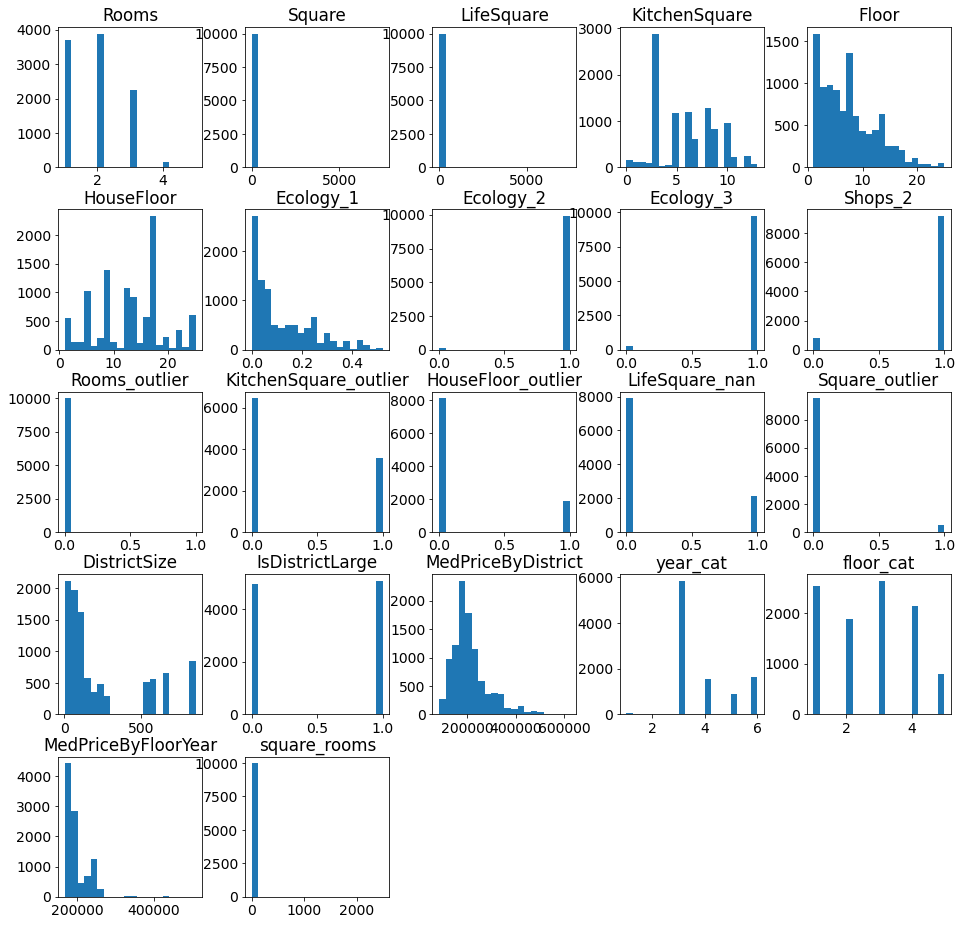

In [76]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

# Матрица корреляций

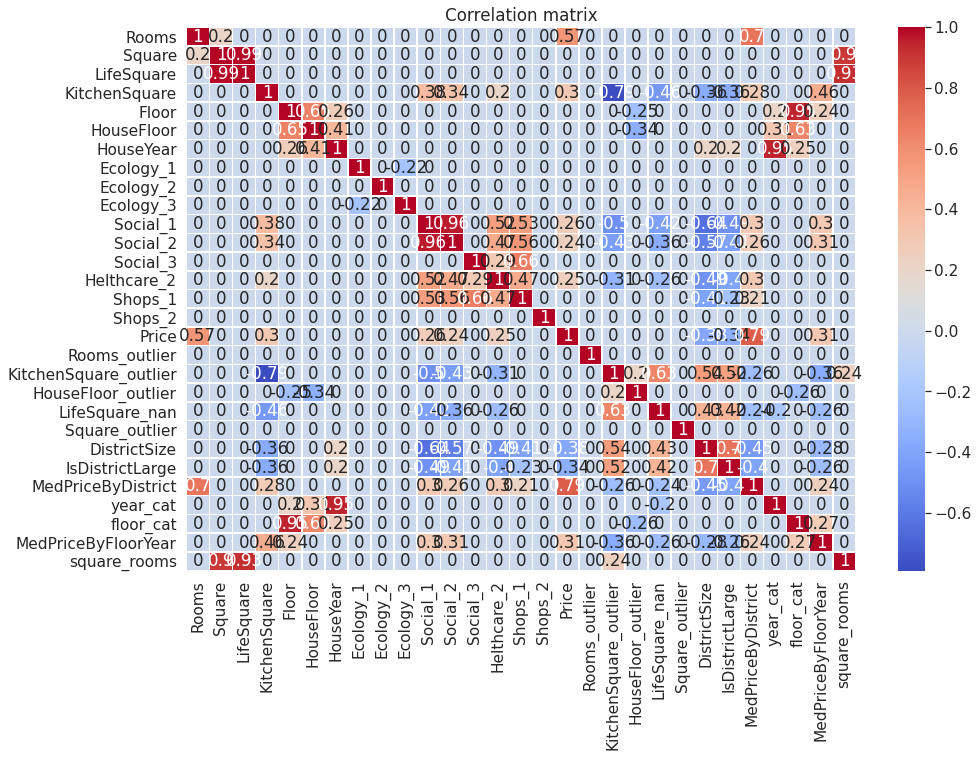

In [77]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

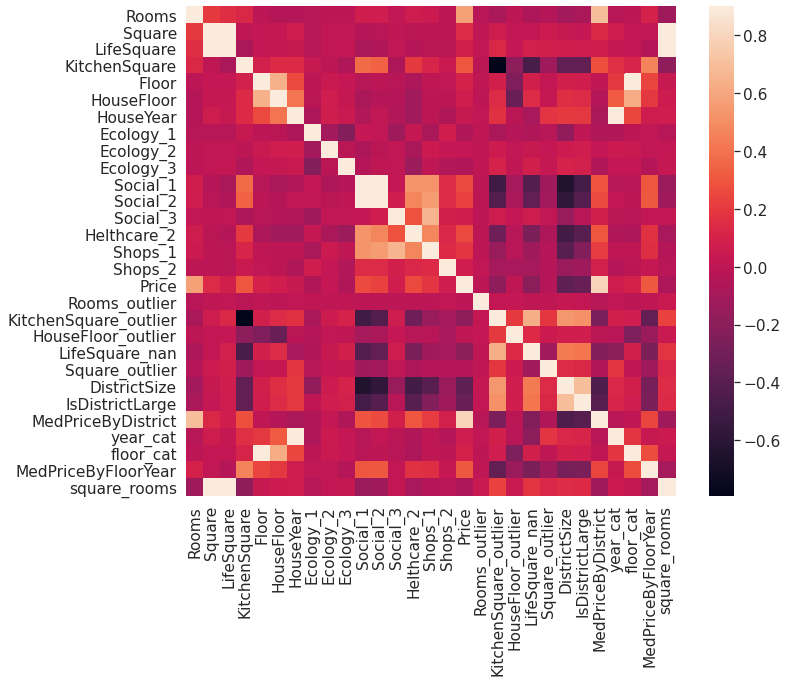

In [78]:
corrmat = train_df.loc[:, train_df.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)


# 6. Отбор признаков


In [79]:
train_df.columns.tolist()


['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Square_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'square_rooms']

In [80]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

new_feature_names = ['Rooms_outlier',
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Square_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'MedPriceByFloorYear']

target_name = 'Price'


# 6. Разбиение на train и test

In [81]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)


X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)


In [83]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [84]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 36), (3300, 36), (5000, 36))

In [85]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [86]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()


(0, 0, 0)

In [87]:
X_train = reduce_mem_usage(X_train)
X_valid = reduce_mem_usage(X_valid)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.38 MB
Memory usage after optimization is: 0.42 MB
Decreased by 69.4%
Memory usage of dataframe is 0.68 MB
Memory usage after optimization is: 0.21 MB
Decreased by 69.4%
Memory usage of dataframe is 1.03 MB
Memory usage after optimization is: 0.32 MB
Decreased by 68.5%


In [88]:
test_df.dtypes

DistrictId                 int16
Rooms                    float32
Square                   float32
LifeSquare               float32
KitchenSquare            float32
Floor                       int8
HouseFloor               float32
HouseYear                  int16
Ecology_1                float32
Ecology_2                   int8
Ecology_3                   int8
Social_1                    int8
Social_2                   int16
Social_3                   int16
Helthcare_2                 int8
Shops_1                     int8
Shops_2                     int8
Rooms_outlier               int8
KitchenSquare_outlier    float32
HouseFloor_outlier          int8
LifeSquare_nan              int8
Square_outlier              int8
DistrictSize             float32
IsDistrictLarge             int8
MedPriceByDistrict       float32
MedPriceByFloorYear      float32
dtype: object

In [89]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# ***Gradient Boosting decision trees***

In [90]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=110,
                                     random_state=20,  
                                     n_estimators=300)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

Train R2:	0.851
Test R2:	0.715


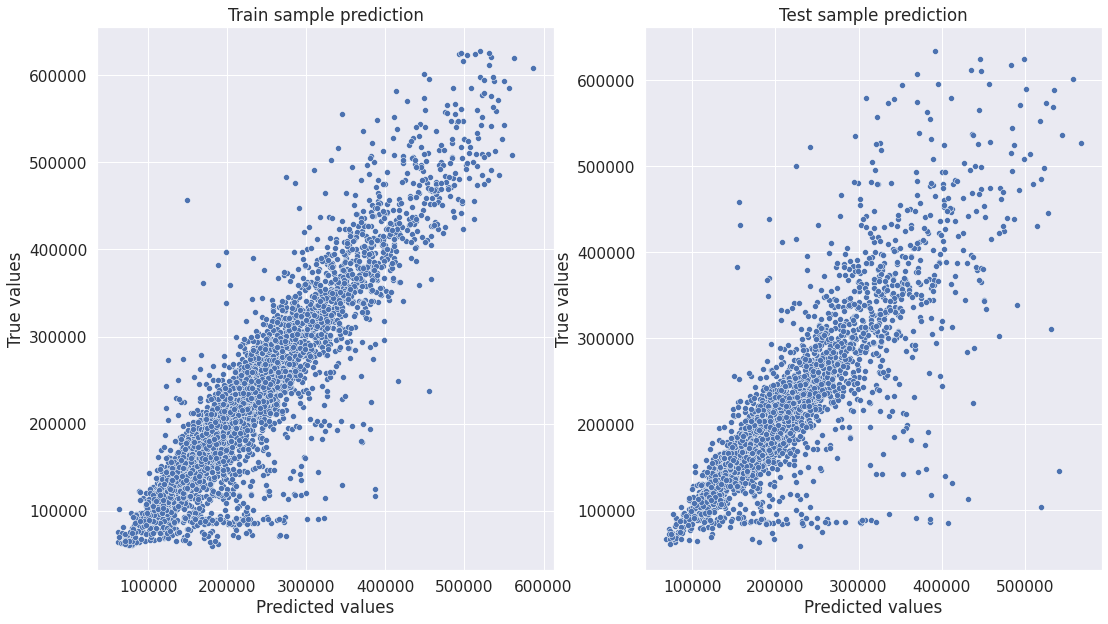

In [91]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

####Кросс-валидация




In [92]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=20))
cv_score

array([0.78449328, 0.75165564, 0.73444189, 0.76146183, 0.75753583])

In [93]:
cv_score.mean()


0.7579176936529148

***Важность признаков¶***


In [94]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,MedPriceByDistrict,0.739883
2,Square,0.104315
13,Social_3,0.019715
22,DistrictSize,0.016760
25,MedPriceByFloorYear,0.016179
7,HouseYear,0.012660
8,Ecology_1,0.011857
11,Social_1,0.011707
6,HouseFloor,0.011478
3,LifeSquare,0.011220


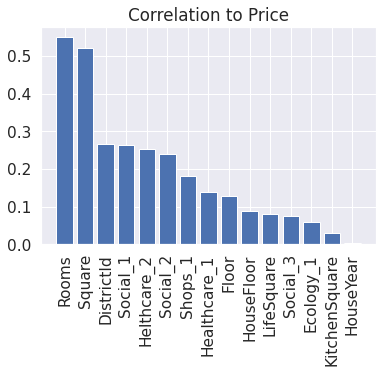

In [95]:

corrmat = train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

Наивысшая ценность у признака "MedPriceByDistrict" - 74%, это очень большой признак и попробовав отказаться от него, модель стала работать лучше ( R2 стал 0,75 против 0,715.
Также можно отказаться от наименее весомых признаков (возьмем 3 с конца) и построим модель повторно:

In [96]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

new_feature_names = [
 'KitchenSquare_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Square_outlier',
 'DistrictSize',
 'MedPriceByFloorYear']

target_name = 'Price'


In [97]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [98]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=30,
                                     random_state=20,  
                                     n_estimators=200)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

После удаления 4х признаков, а также поиска наилучших параметров с помощью  GridSearchCV , мы улучшили метрику:

*Было*:

Train R2:	0.851

Test R2:	0.716


*Стало*:

Train R2:	0.809

Test R2:	0.749

GridSearchCV производилось по следующим параметрам:
params = {'n_estimators':[50, 100, 200, 400], 
          'min_samples_leaf':[50, 100, 200, 400],
          'max_depth':[ 4,   7,  11, 15]}
Наилучшие результаты были:
{'max_depth': 4, 'min_samples_leaf': 50, 'n_estimators': 200}

А затем по этим:

gs.best_params_
{'max_depth': 5, 'min_samples_leaf': 30, 'n_estimators': 200}

Train R2:	0.85
Test R2:	0.751


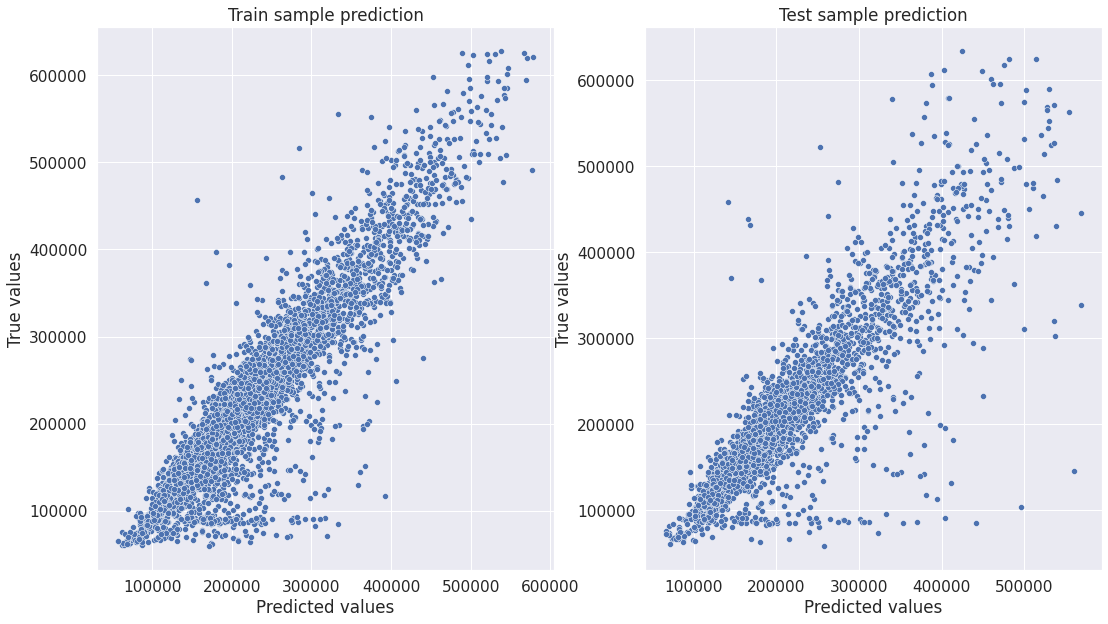

In [99]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

[125]
gs.best_params_
{'max_depth': 5, 'min_samples_leaf': 30, 'n_estimators': 200}

In [100]:
# gs.best_params_

#8. Прогнозирование на тестовом датасете
Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Не потерять и не перемешать индексы от примеров при построении прогнозов
Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [101]:
test_df.shape


(5000, 22)

In [102]:
test_df


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,KitchenSquare_outlier,HouseFloor_outlier,LifeSquare_nan,Square_outlier,DistrictSize,MedPriceByFloorYear
0,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,1,24,4378,0,1,1,1,244898.171875,0,0,0,76.0,189145.453125
1,62,1.0,42.568134,29.568132,10.0,7,17.0,2017,0.072158,1,2,629,1,0,0,0,244898.171875,0,0,1,164.0,175233.890625
2,27,2.0,59.463676,47.463676,9.0,19,19.0,1977,0.211401,1,9,1892,0,0,1,1,244898.171875,0,1,0,580.0,173028.984375
3,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,1,2,475,0,0,0,1,244898.171875,0,0,0,372.0,179400.125000
4,74,1.0,53.837055,47.837055,3.0,8,17.0,1977,0.309479,1,35,7715,4,0,6,1,244898.171875,0,1,0,65.0,192984.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,2.0,43.177521,30.339945,5.0,3,5.0,1962,0.069660,1,31,6119,4,1,2,1,244898.171875,1,0,0,56.0,179400.125000
4996,38,3.0,94.521461,81.521461,10.0,21,25.0,2018,0.060753,1,15,2787,2,0,7,1,244898.171875,1,0,1,26.0,193054.218750
4997,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,1,28,6533,1,2,5,1,244898.171875,0,0,0,54.0,179400.125000
4998,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,33,7976,5,0,11,1,244898.171875,0,0,0,40.0,192984.062500


In [103]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [104]:
predicts = gb_model.predict(test_df)
predicts

array([164409.47964089, 126713.4960566 , 148527.68202726, ...,
       146014.33891716, 191992.11852797, 256438.52948512])

In [105]:
submit['Price'] = predicts
submit.head()

,Id,Price
0,4567,164409.479641
1,5925,126713.496057
2,960,148527.682027
3,3848,127954.552290
4,746,201863.865678


In [106]:
submit.to_csv('/content/drive/MyDrive/Colab Notebooks/train-prepared.csv', index=False)

In [107]:
submit_check = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final.csv')
submit_check.head()

,Id,Price
0,4567,167629.126710
1,5925,127238.701249
2,960,145174.913698
3,3848,128905.834720
4,746,200636.867824
